# 20240119 中心推定の精度比較

#### 概要  
  
今回の研究では「ALD法」を提案した．（計算方法は別紙参照）  
これは，EV法，GM法と同様にクリスプな値を推定するAHP手法である．  
  
今回は，以下の２つの方法によってこれらの中心推定の精度を比較する．用いたデータは，A, B, C, D, E の５種の区間重要度から生成されたPCM（それぞれ1000個）である．  
- 中心推定の正解数  
評価基準数=N のPCMに対してEV, GM, ALDを適用し，推定される重要度が元の区間重要度に含まれるかを判定する．  
結果はヒストグラムで表し，正解数の期待値も求める．  
- 中心からの距離  
与えられた区間重要度の中心を「真の値」ととらえ，EV, GM, ALDによって推定された値がそこからどれだけ離れているかを計算する．  
重要度の差異を表現する値として，Euclid Distanceを用いる

In [101]:
# import Pkg
# Pkg.add("Plots")
# Pkg.add("DataFrames")
# Pkg.add("CSV")
# Pkg.add("IntervalSets")
# Pkg.add("LatexStrings")

In [ ]:
using DataFrames, CSV
using IntervalArithmetic
using LaTeXStrings
using Statistics
using Plots
# using Base
include("./libs/display-latex.jl")
include("./libs/crisp-pcm.jl")
include("./libs/solve-deterministic-ahp.jl")
include("./libs/analysis-indicators.jl")

In [103]:
# 評価基準数
num_criteria = [4, 5, 6, 7, 8];
# 真の区間重要度のセッティング
true_importance = ["A", "B", "C", "D", "E"]; # ["A", "B", "C", "D", "E"]

In [ ]:
function displayHistogram(result, euclidean, N, setting)
    list_p = []
    titles = ["EV", "GM", "ALD"]
    for i in eachindex(result)
        p = histogram(
            result[i],
            ylims = (0, 850),
            bins = 0:1:N+1,
            legend=false,
            title = "N=$N, $setting, " * titles[i]
        )
        mean_value = round(mean(result[i]), digits=5)
        euclidean_value = round(euclidean[i], digits=5)
        annotate!(p, [(0, 800, text("Mean = $mean_value", :left, 10))])
        annotate!(p, [(0, 750, text("Euclidean = $euclidean_value", :left, 10))])

        push!(list_p, p)
    end
    display(plot(list_p..., layout=(1, 3), size=(1200, 350)))
end

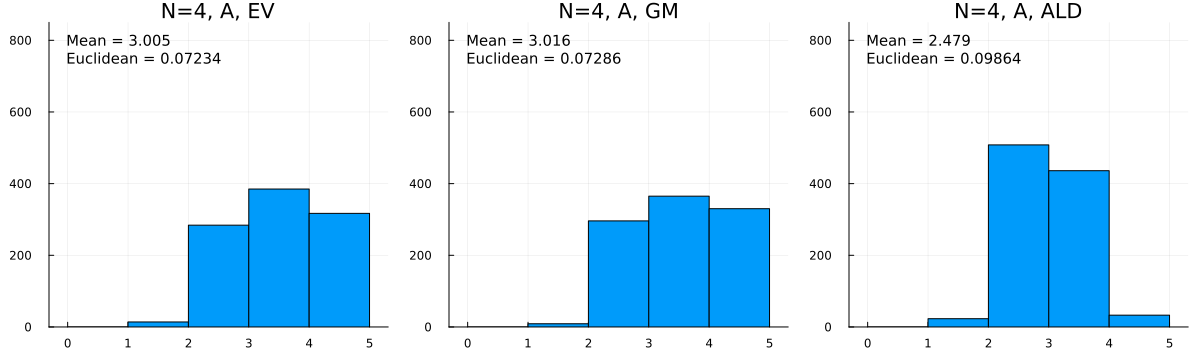

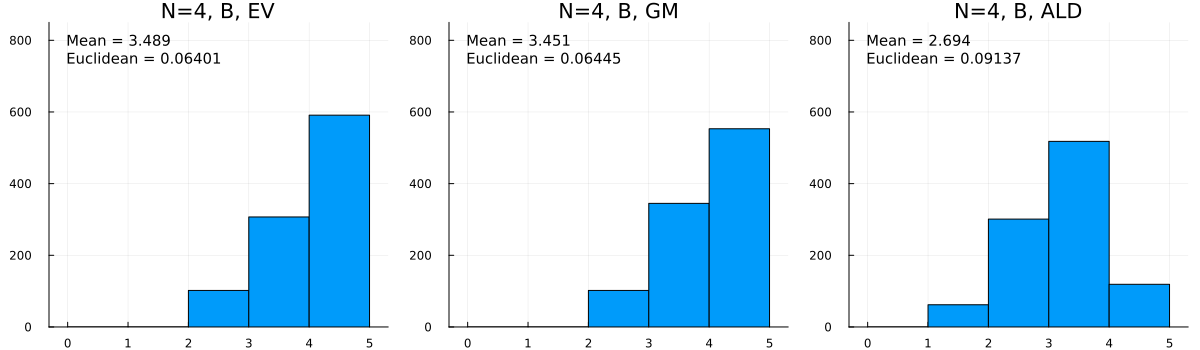

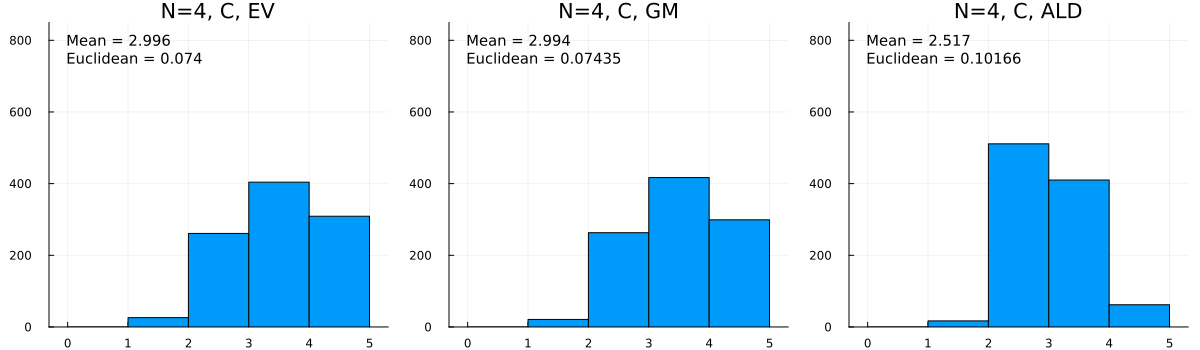

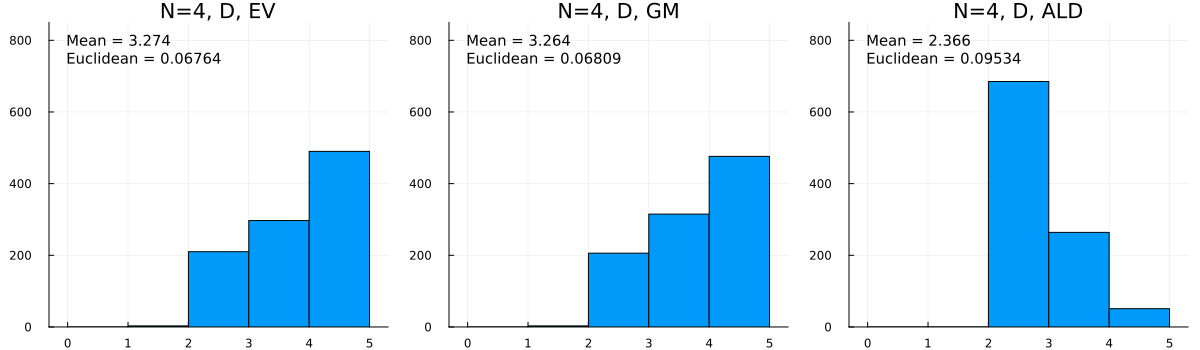

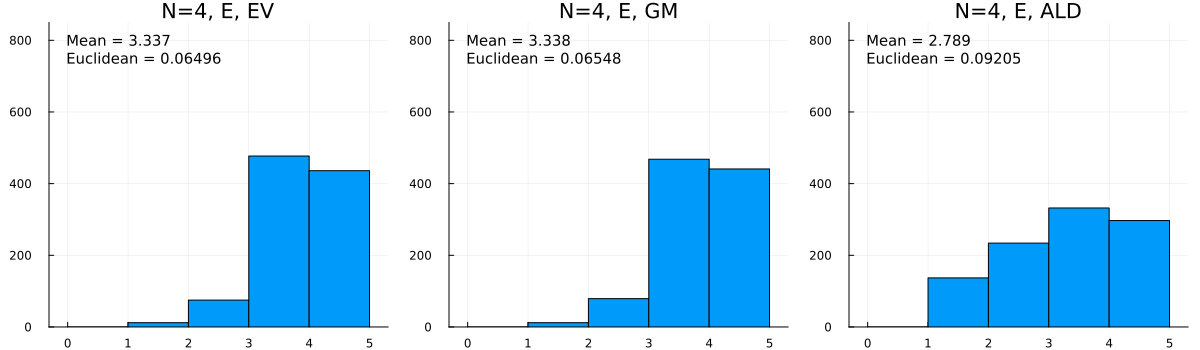

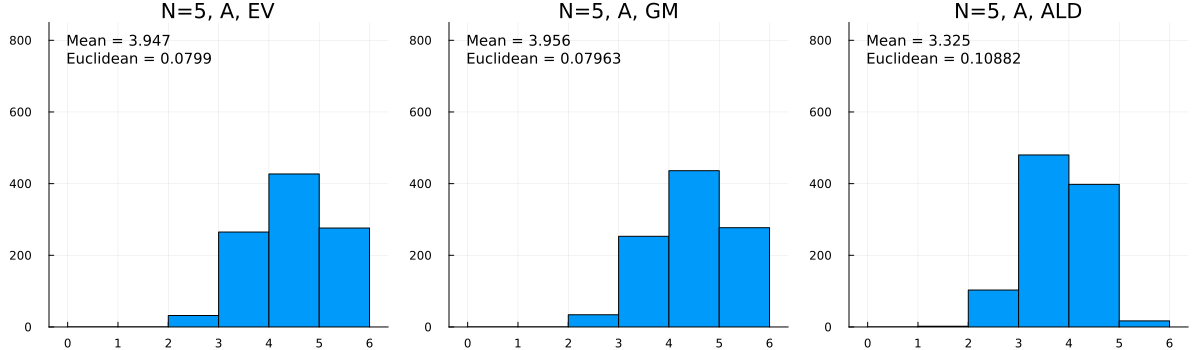

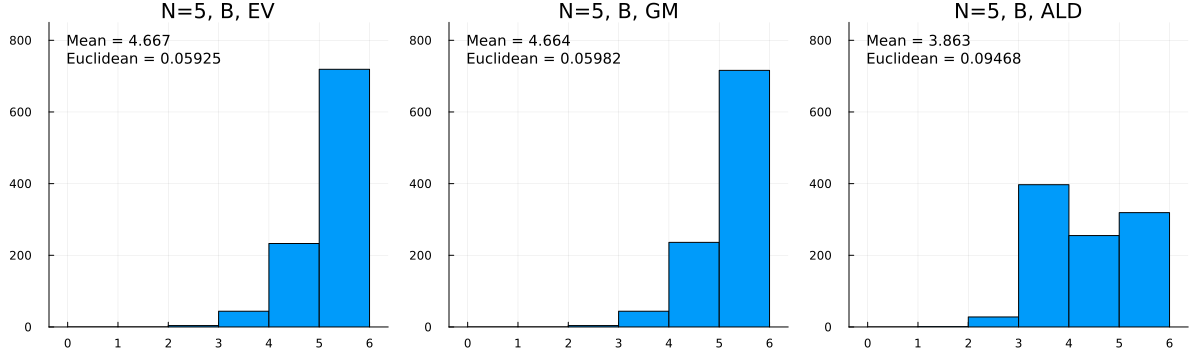

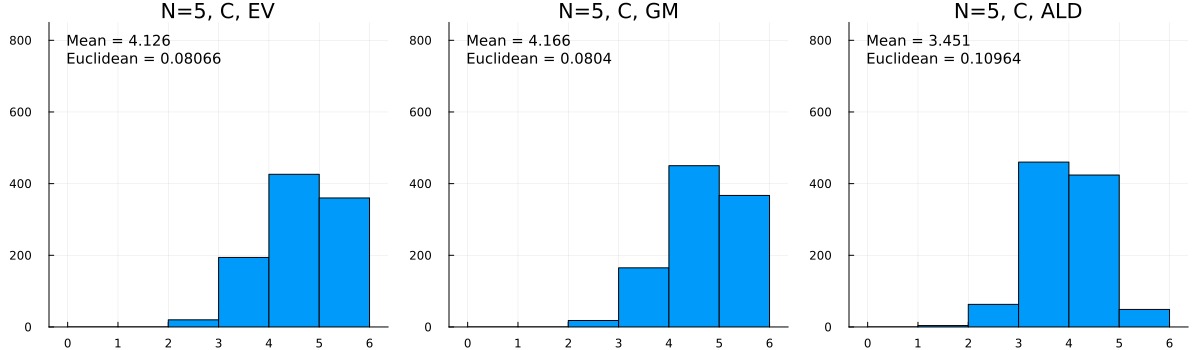

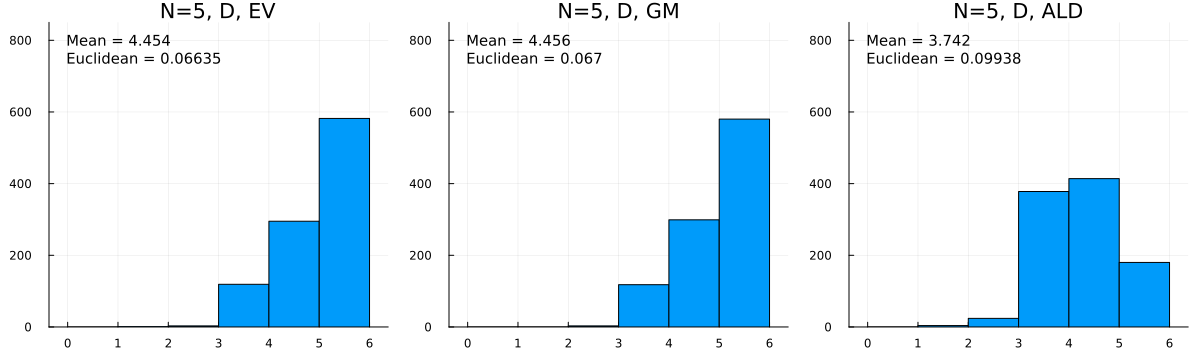

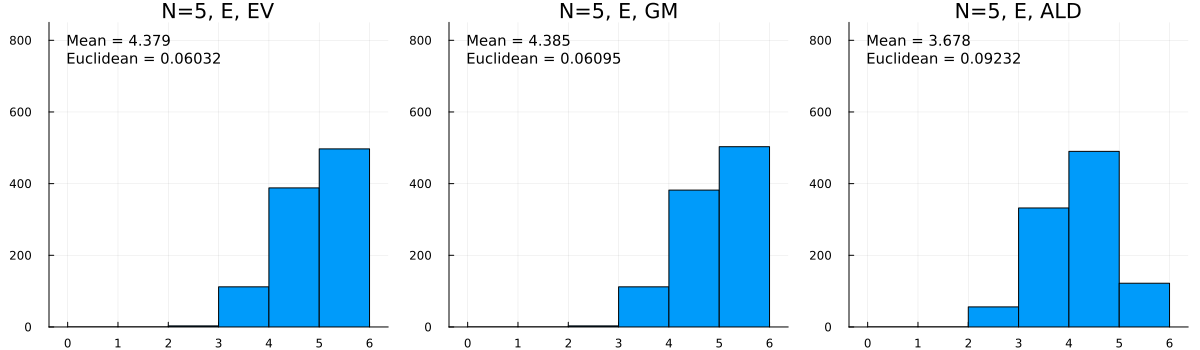

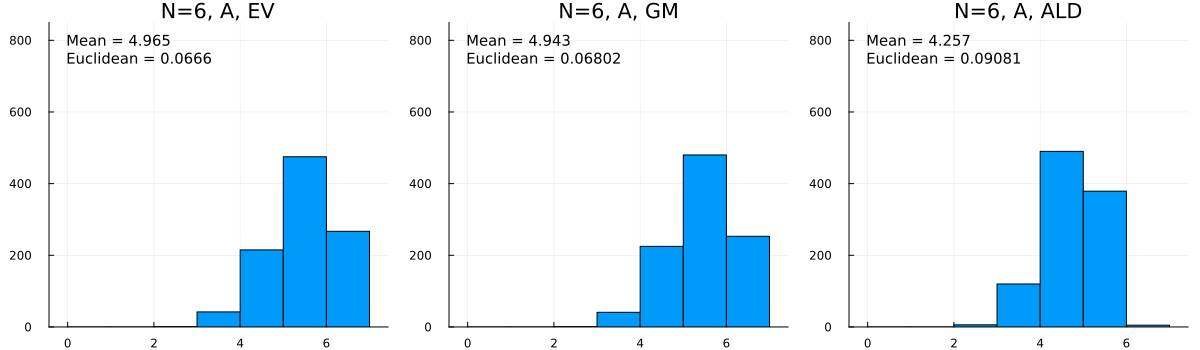

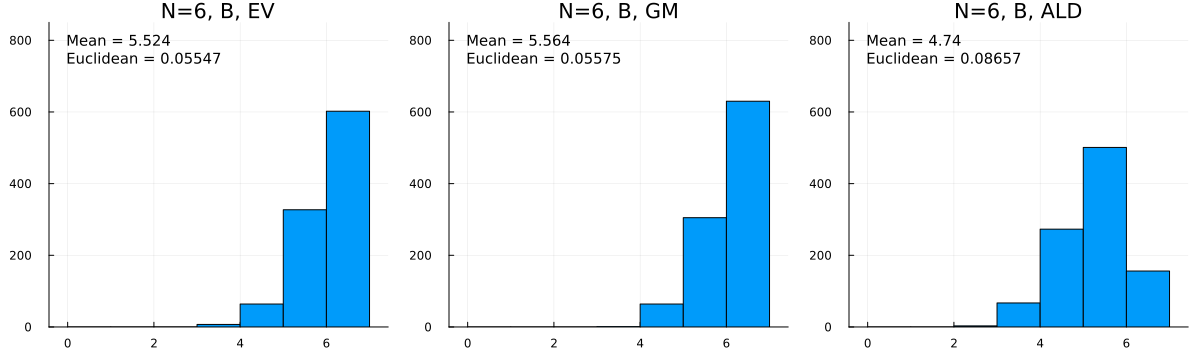

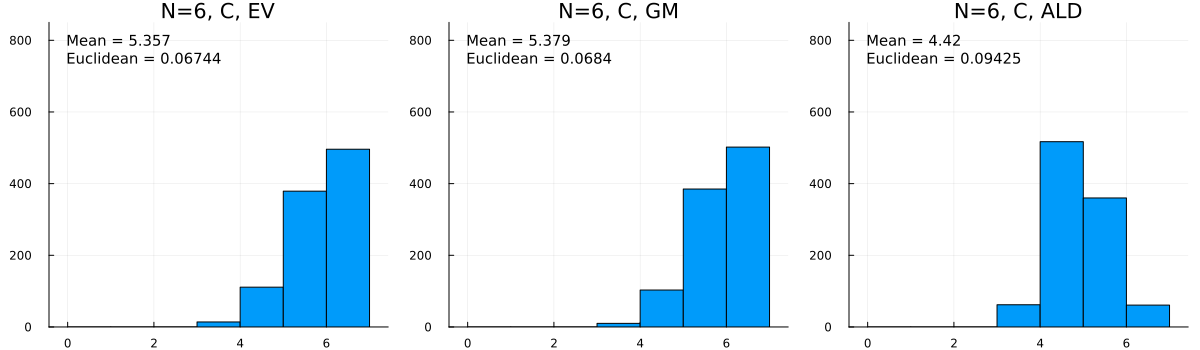

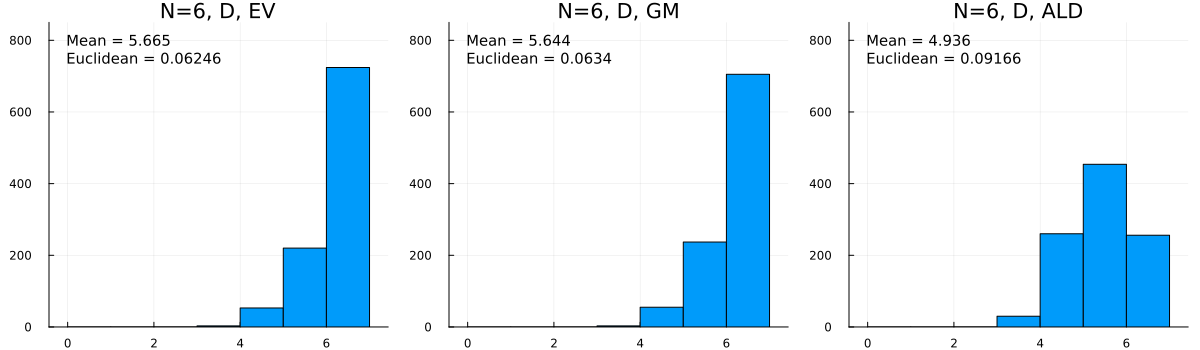

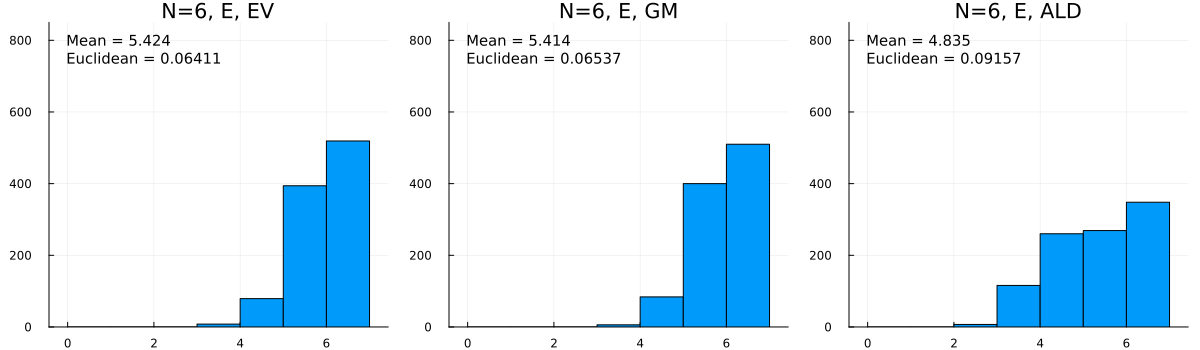

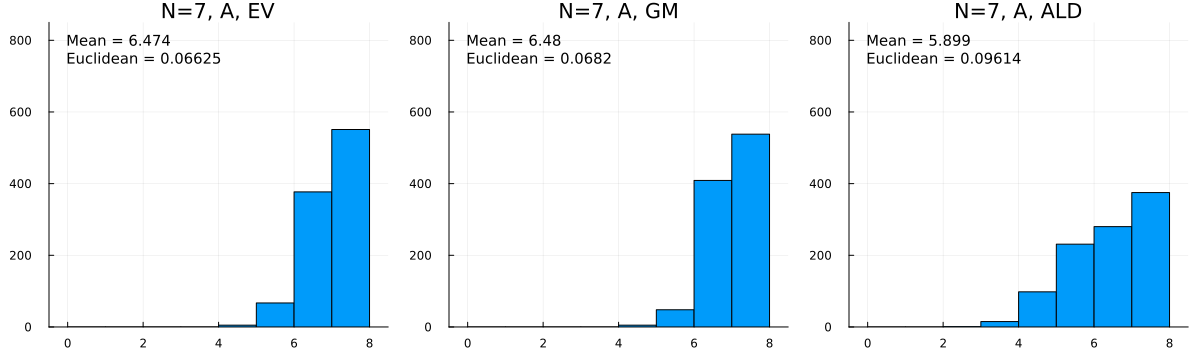

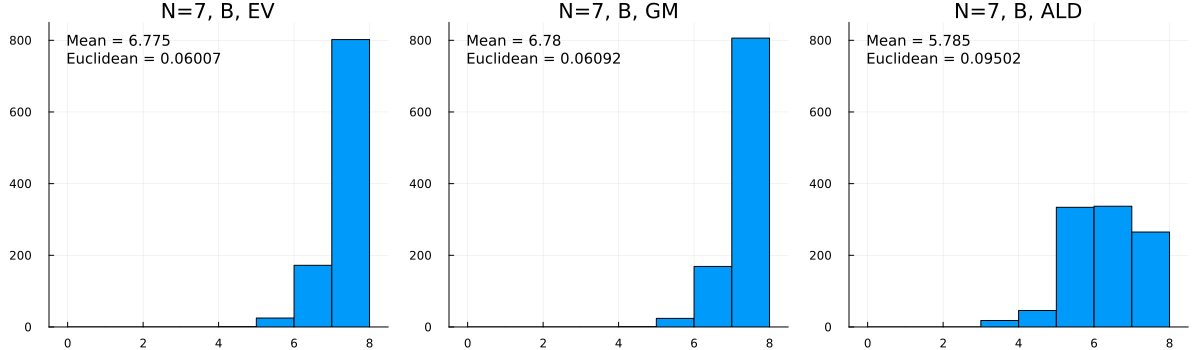

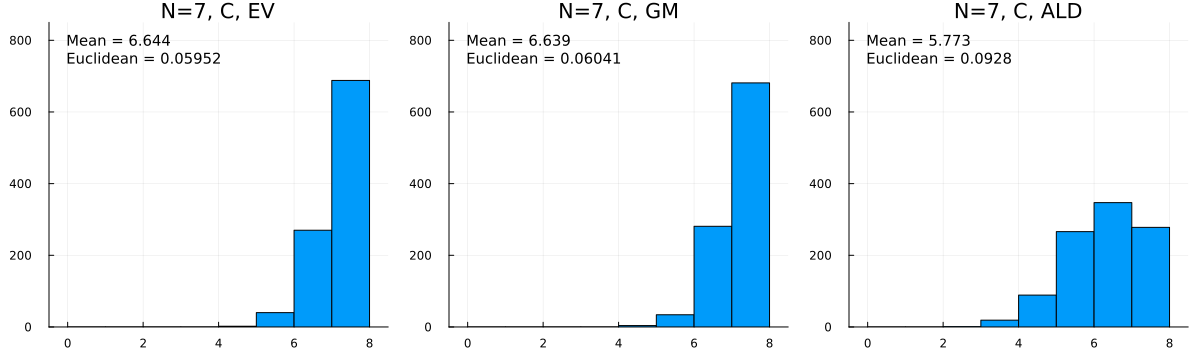

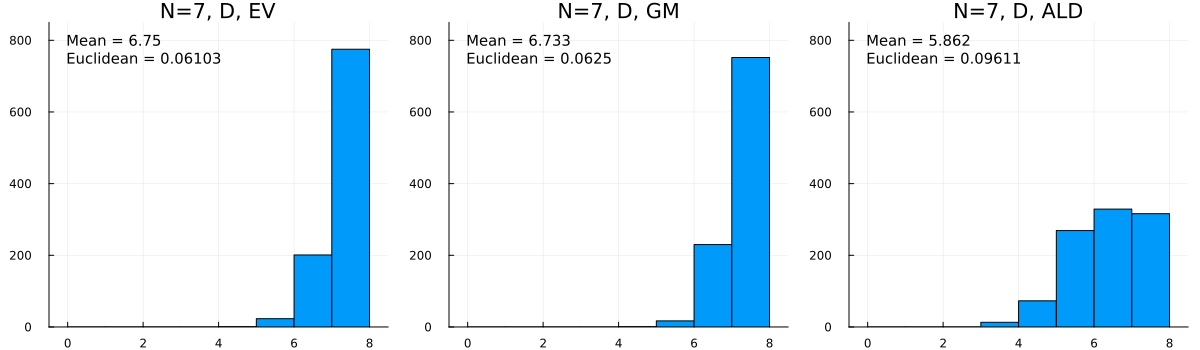

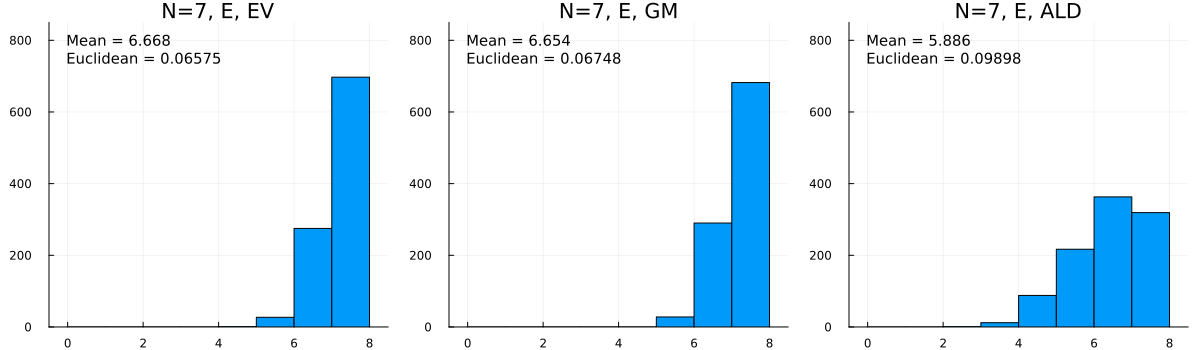

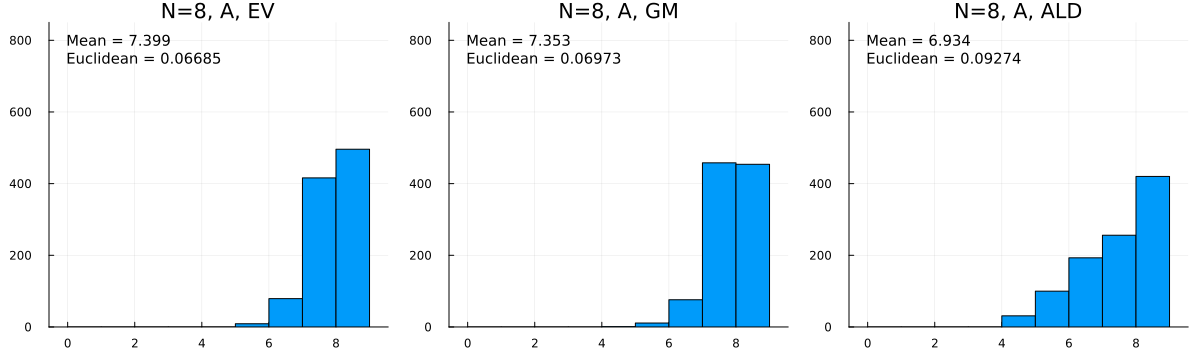

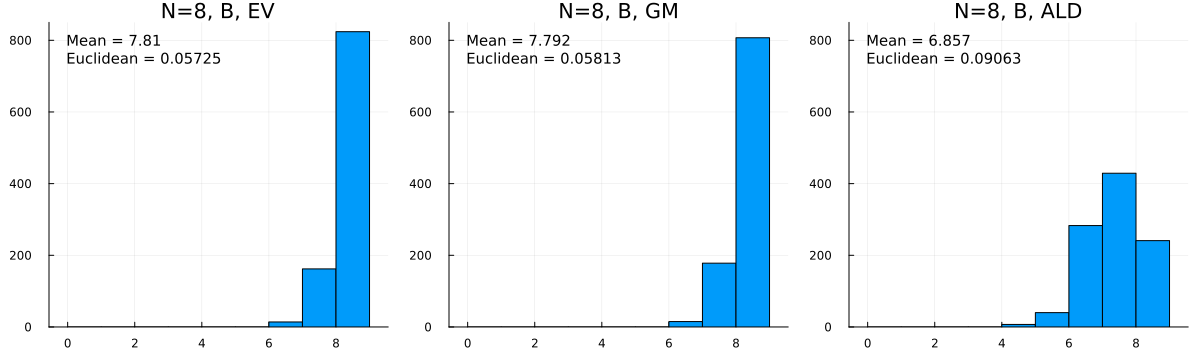

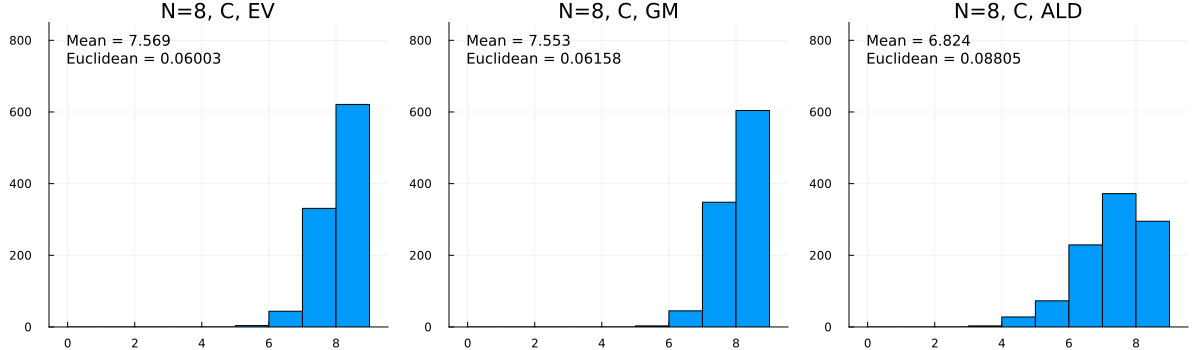

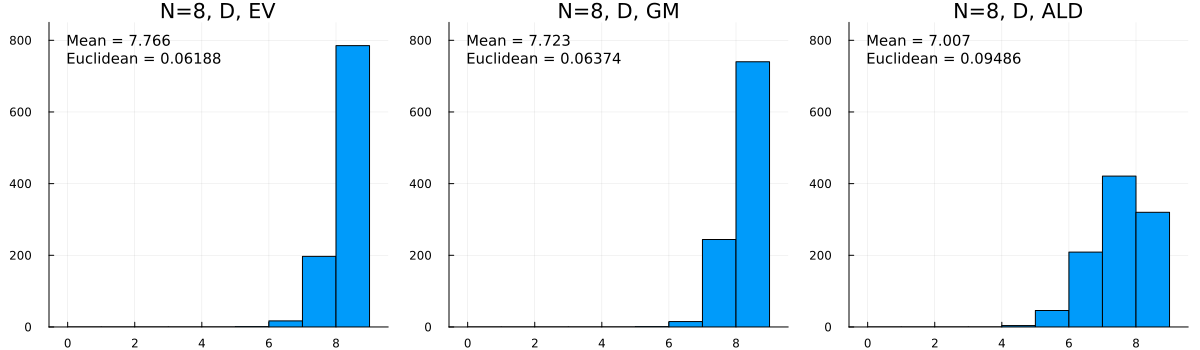

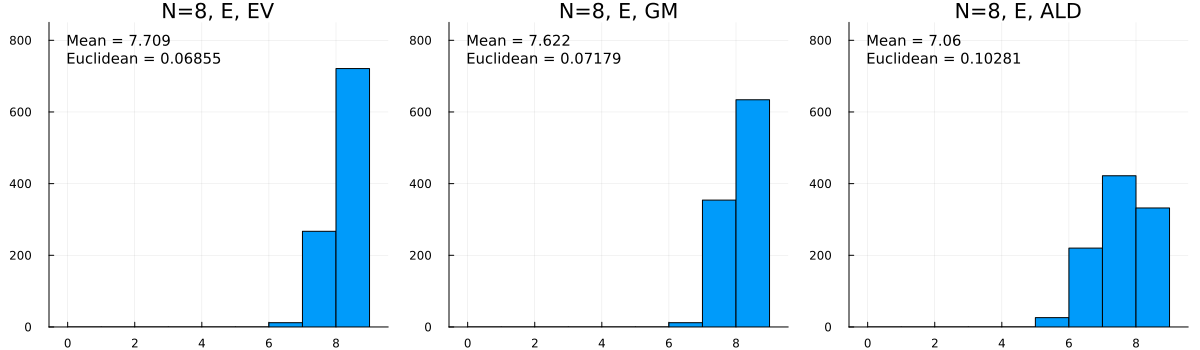

In [105]:
# 真の区間重要度を読み込み
for N in num_criteria
        
    for setting in true_importance
        

        df = CSV.File("./data/N"*string(N)*"_"*setting*"_Given_interval_weight.csv", header=false) |> DataFrame
        T = Vector{Interval{Float64}}() # Float64のところにTを使うとおかしくなるのはなぜか？
        for i in 1:N
            push!(T, interval(df[1, 2*i-1], df[1, 2*i]))
        end

        # display(L"T = %$(intervalVectorLaTeXString(T))")
        # 一対比較行列を1000個読み込み
        df1 = CSV.File("./data/N"*string(N)*"_a3_"*setting*"_PCM_int.csv", header=false) |> DataFrame

        # データフレームをN×Nのサブデータフレームに分割
        subdfs = split_dataframe(df1, N);
        # 結果格納用
        EV_in_range = Vector{Int64}(undef, 1000)
        GM_in_range = Vector{Int64}(undef, 1000)
        ALD_in_range = Vector{Int64}(undef, 1000)
        

        EV_euclidean = Vector{Float64}(undef, 1000)
        GM_euclidean = Vector{Float64}(undef, 1000)
        ALD_euclidean = Vector{Float64}(undef, 1000)

        # 1000個のデータで推定
        for (i, subdf) in enumerate(subdfs)

            # 一対比較行列を取り出す
            A = Matrix(subdf)

            # 重要度推定
            est_EV = EV(A)
            est_GM = GM(A)
            est_ALD = ALD(A)

            EV_in_range[i] = est_in_range(T, est_EV) # 真の区間重要度と推定値の積集合の割合
            GM_in_range[i] = est_in_range(T, est_GM) # 真の区間重要度と推定値の積集合の割合
            ALD_in_range[i] = est_in_range(T, est_ALD) # 真の区間重要度と推定値の積集合の割合
            EV_euclidean[i] = caluculate_euclidean(interval_centers(T), est_EV) # 真の区間重要度中心と推定値のユークリッド距離
            GM_euclidean[i] = caluculate_euclidean(interval_centers(T), est_GM) # 真の区間重要度中心と推定値のユークリッド距離
            ALD_euclidean[i] = caluculate_euclidean(interval_centers(T), est_ALD) # 真の区間重要度中心と推定値のユークリッド距離
        end

        euclidean = [mean(EV_euclidean), mean(GM_euclidean), mean(ALD_euclidean)]
        in_range = [EV_in_range, GM_in_range, ALD_in_range]
        displayHistogram(in_range, euclidean, N, setting)
    end
    
end